# Portfolio optimization example

### JunyuSui 

## Load Packages

In [1]:
import pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from statsmodels.formula.api import ols
from scipy.stats import gaussian_kde
import scipy
import scipy.sparse
import patsy
from statistics import median
import bz2
import math

In [2]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, ElasticNetCV, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

## Load Data

The model data has already been pre-processed from text files and saved into pickle files. Loading and parsing the raw files (parsing text into numbers) can slow down your backtest significantly, which is why it's important to pre-process the data beforehand.

In [3]:
model_dir = '/Users/suijunyu/Desktop/ML_project/project_data/'

def sort_cols(test): 
    return(test.reindex(sorted(test.columns), axis=1))

frames = {}
for year in [2004,2005,2006]:
    fil = model_dir + "pandas-frames." + str(year) + ".pickle.bz2"
    frames.update(pickle.load( bz2.open( fil, "rb" ) ))

for x in frames: 
    frames[x] = sort_cols(frames[x])
    
covariance = {}
for year in [2003,2004,2005,2006]:
    fil = model_dir + "covariance." + str(year) + ".pickle.bz2"
    covariance.update(pickle.load( bz2.open(fil, "rb" ) ))

ID: a unique identifier that can be used to link stocks across time 

1DREVRSL: very short-term reversal, potential alpha factor but probably too fast-moving to be tradable 

STREVRSL: short-term reversal, potential alpha factor 

LTREVRSL: long-term reversal, potential alpha factor 

BETA: risk factor computed from CAPM beta regression

EARNQLTY: earnings quality, potential alpha factor 

EARNYILD: earnings yield (blend of forecasted earnings and historical earnings divided by market cap) 

GROWTH: mix of historical and forecasted earnings growth 

LEVERAGE: financial leverage of the company's balance sheet, usually a risk factor 

LIQUIDTY: factor with high loadings for very liquidly traded names; usually a risk factor 

MGMTQLTY: management quality, potential alpha factor which looks at quantitative measures of how well-run a company is by its management 

MOMENTUM: 12-month growth in stock price, usually a risk factor 

PROFIT: profitability, potential alpha factor 

PROSPECT: based on skewness of the return distribution, potential risk factor 

RESVOL: risk factor computed from residual volatility 

SEASON: seasonality-based alpha factor 

SENTMT: news sentiment alpha factor 

SIZE: risk factor based on log(market capitalization) 

VALUE: risk factor based on ratio of tangible book value to current price 




SpecRisk: specific risk is another name for predicted residual volatility. We called this the D matrix in our discussion of APT models. 

TotalRisk: predicted total vol, including factor and idiosyncratic contributions, annualized 

Ret: asset's total return on the next day after the factor loadings are known, suitable as the Y vector in a regression analysis 

Yield: the dividend yield of the asset 


HistBeta: historically estimated CAPM beta coefficient 
PredBeta: model-predicted beta coefficient in the future 


INDMOM: industry momentum (defined as relative historical outperformance or underperformance of the other stocks in the same industry) 

IssuerMarketCap: aggregate market capitalization of the company (all share classes from the same issuer, e.g. for Google would include both Alphabet A and C) 

BidAskSpread: bid-offer spread (average for the day) 

CompositeVolume: composite trading volume for the day 

DataDate: the date when the data would have been known, as of the close 



Industry factors: 'AERODEF', 'AIRLINES', 'ALUMSTEL', 'APPAREL', 'AUTO',
       'BANKS','BEVTOB', 'BIOLIFE', 'BLDGPROD','CHEM', 'CNSTENG', 'CNSTMACH', 'CNSTMATL', 'COMMEQP', 'COMPELEC',
       'COMSVCS', 'CONGLOM', 'CONTAINR', 'DISTRIB',
       'DIVFIN', 'DIVYILD', 'DWNRISK','ELECEQP', 'ELECUTIL', 'FOODPROD', 'FOODRET', 'GASUTIL',
       'HLTHEQP', 'HLTHSVCS', 'HOMEBLDG', 'HOUSEDUR','INDMACH', 'INSURNCE', 'INTERNET', 
        'LEISPROD', 'LEISSVCS', 'LIFEINS', 'MEDIA', 'MGDHLTH','MULTUTIL',
       'OILGSCON', 'OILGSDRL', 'OILGSEQP', 'OILGSEXP', 'PAPER', 'PHARMA',
       'PRECMTLS','PSNLPROD','REALEST',
       'RESTAUR', 'ROADRAIL','SEMICOND', 'SEMIEQP','SOFTWARE', 'SPLTYRET', 'SPTYCHEM', 'SPTYSTOR',
       'TELECOM', 'TRADECO', 'TRANSPRT', 'WIRELESS'

## Data Cleaning and Winsorization

The distribution of many statistics can be heavily influenced by outliers. A simple approach to robustifying parameter estimation procedures is to set all outliers to a specified percentile of the data; for example, a 90% winsorization would see all data below the 5th percentile set to the 5th percentile, and data above the 95th percentile set to the 95th percentile. Winsorized estimators are usually more robust to outliers than their more standard forms.

In [4]:
def wins(x,a,b):
    return(np.where(x <= a,a, np.where(x >= b, b, x)))

def clean_nas(df): 
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    for numeric_column in numeric_columns: 
        df[numeric_column] = np.nan_to_num(df[numeric_column])
    
    return df

We can check the distribution of returns with a density plot, both before and after winsorization to observe the effect of trimming the tails.

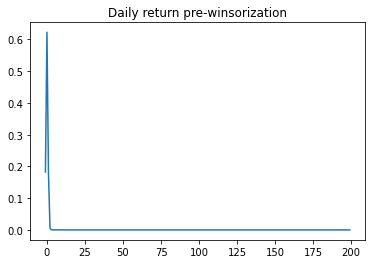

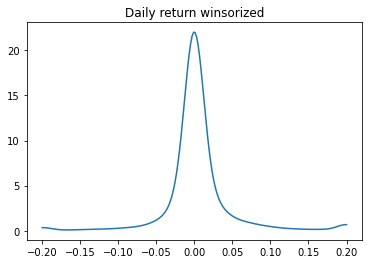

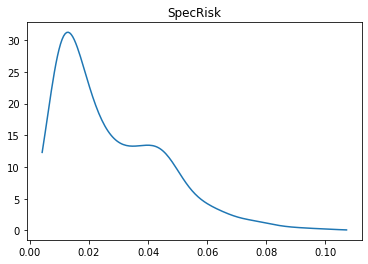

In [5]:
def density_plot(data, title): 
    density = gaussian_kde(data)
    xs = np.linspace(np.min(data),np.max(data),200)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    plt.plot(xs,density(xs))
    plt.title(title)
    plt.show()
    
test = frames['20040102']
density_plot(test['Ret'], 'Daily return pre-winsorization')
density_plot(wins(test['Ret'],-0.2,0.2), 'Daily return winsorized')

D = (test['SpecRisk'] / (100 * math.sqrt(252))) ** 2
density_plot(np.sqrt(D), 'SpecRisk')

# Factors

## Factor Exposures and Factor Returns


Arbitrage pricing theory relaxes several of the assumptions made in the course of deriving 
the CAPM. In particular, we relax the assumption that all investors do the same optimization 
and hence that there is a single efficient fund. This allows the possibility that a CAPM-like 
relation may hold, but with multiple underlying sources of risk. 

Specifically, let $r_i, i = 1, \ldots, n$ denote the cross-section of asset returns over a given 
time period $[t, t+1]$. In a fully-general model, the multivariate distribution $p(\mathbf{r})$ could have 
arbitrary covariance and higher-moment structures, but remember that for $n$ large there is 
typically never enough data to estimate such over-parameterized models. 

Instead, we assume a
structural model which is the most direct generalization of the CAPM: 
$$
	r_i = \beta_{i, 1} f_1 + \beta_{i,2} f_2 + \dots + \beta_{i, p} f_p + \epsilon_i, \quad 
	\epsilon_i \sim N(0, \sigma_i^2)  
$$
If $p = 1$, this reduces to the Capital Asset Pricing Model (CAPM) in a rather direct way. 

With $p > 1$, the model starts to differ from the CAPM 
in several very important aspects. In the CAPM, we were 
able to identify the single efficient fund by arguing that its weights must equal the 
market-capitalization weights. Hence we were given for free a very nice proxy for the 
single efficient fund: a capitalization-weighted basket such as the Russell 3000. 
Hence in the $p=1$ case we had a convenient proxy which could be used to impute 
the return $f_1$, which we called $r_M$. Also $\beta_{i, 1}$ could be estimated, with 
no more than the usual statistical estimation error, by time-series regression. 

If $p > 1$ then the underlying assumptions of that argument break down: there is no
longer any simple way to identify $f_{j}$ nor $\beta_{i, j}$ ($j = 1, \ldots, p$). 
We shall return to the estimation problem in due course. 


To avoid confusion with the CAPM, and its simplistic $\beta$ coefficient (which is still 
sometimes used in larger multi-factor models), it is conventional to make the following 
notation change: $\beta_{i,j}$ becomes $X_{i,j}$ and so the model equation becomes 
$$
	 	r_i = X_{i, 1} f_1 + X_{i,2} f_2 + \dots + X_{i, p} f_p + \epsilon_i, \quad 
	\epsilon_i \sim N(0, \sigma_i^2)  
$$
It's difficult to simultaneously estimate both all components $X_{i,j}$ and all risk-source 
returns $f_j$, so one usually assumes one is known and calculates the other via regression. 
In what follows, we focus on the approach where $X$ is known, and the $f_j$ are assumed
to be hidden (aka latent) variables.

The structural equation is more conveniently expressed in matrix form: 
$$
	R_{t+1} = X_t f_{t+1} + \epsilon_{t+1}, \quad E[\epsilon] = 0, \ \ V[\epsilon] = D 
$$
where $R_{t+1}$ is an $n$-dimensional random vector containing the 
cross-section of returns in excess of the risk-free rate over some 
time interval $[t, t+1]$, and $X_t$ is a (non-random) $n \times p$ matrix 
that can be calculated entirely from data known before time $t$.
The variable $f$ in denotes a $p$-dimensional random vector
process which cannot be observed directly. 

Since the variable $f$ denotes a $p$-dimensional random vector process which cannot 
be observed directly, information about the $f$-process must be obtained via statistical inference. 
We assume that the $f$-process has finite first and second moments given by 
$$
	E[f] = \mu_f, \ \text{ and } \  V[f] = F . 
$$ 
The primary outputs of a statistical inference process are the parameters 
$\mu_f$ and $F$, and other outputs one might be interested in
include estimates of the daily realizations $\hat{f}_{t+1}$. 

The simplest way of estimating historical daily realizations of $\hat{f}_{t+1}$ is by least-squares (ordinary or weighted, as appropriate), viewing the defining 
model equation as a regression problem. 

In [6]:
industry_factors = ['AERODEF', 'AIRLINES', 'ALUMSTEL', 'APPAREL', 'AUTO',
       'BANKS','BEVTOB', 'BIOLIFE', 'BLDGPROD','CHEM', 'CNSTENG', 'CNSTMACH', 'CNSTMATL', 'COMMEQP', 'COMPELEC',
       'COMSVCS', 'CONGLOM', 'CONTAINR', 'DISTRIB',
       'DIVFIN', 'DIVYILD', 'DWNRISK','ELECEQP', 'ELECUTIL', 'FOODPROD', 'FOODRET', 'GASUTIL',
       'HLTHEQP', 'HLTHSVCS', 'HOMEBLDG', 'HOUSEDUR','INDMACH', 'INSURNCE', 'INTERNET', 
        'LEISPROD', 'LEISSVCS', 'LIFEINS', 'MEDIA', 'MGDHLTH','MULTUTIL',
       'OILGSCON', 'OILGSDRL', 'OILGSEQP', 'OILGSEXP', 'PAPER', 'PHARMA',
       'PRECMTLS','PSNLPROD','REALEST',
       'RESTAUR', 'ROADRAIL','SEMICOND', 'SEMIEQP','SOFTWARE', 'SPLTYRET', 'SPTYCHEM', 'SPTYSTOR',
       'TELECOM', 'TRADECO', 'TRANSPRT', 'WIRELESS']

style_factors = ['BETA','SIZE','MOMENTUM','VALUE']

In [7]:
def get_formula(alphas, Y):
    L = ["0"]
    L.extend(alphas)
    L.extend(style_factors)
    L.extend(industry_factors)
    return Y + " ~ " + " + ".join(L)

def get_estu(df): 
    estu = df.loc[df.IssuerMarketCap > 1e9].copy(deep=True)
    return estu

def estimate_factor_returns(df, alphas): 
    ## build universe based on filters 
    estu = get_estu(df)
    
    ## winsorize returns for fitting 
    estu['Ret'] = wins(estu['Ret'], -0.25, 0.25)
  
    form = get_formula(alphas, "Ret")
    model = ols(form, data=estu)
    results = model.fit()
    return(results)

Running one OLS per day over several years, where each OLS involves several thousand observations and about 50-100 independent variables, takes a few minutes.

In [8]:
alpha_factors = ['STREVRSL','PROFIT','SENTMT']

In [9]:
facret = {}

for date in frames:
    facret[date] = estimate_factor_returns(frames[date], list(alpha_factors)).params

In [10]:
my_dates = sorted(list(map(lambda date: pd.to_datetime(date, format='%Y%m%d'), frames.keys())))

## Alpha factor selection

In a real trading scenario, alpha factor construction would be the culmination of a very long research process, usually undertaken by experts in financial markets and requiring great cost and ingenuity. 
For this exercise, we consider several well-known alpha factors: (reversal, profitability, and sentiment).

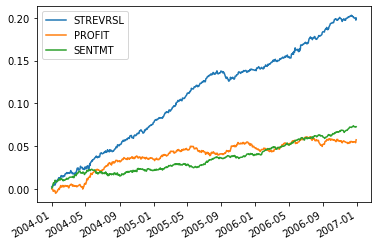

In [11]:
facret_df = pd.DataFrame(index = my_dates)

for dt in my_dates: 
    for alp in alpha_factors: 
        facret_df.at[dt, alp] = facret[dt.strftime('%Y%m%d')][alp]

facret_df.cumsum().plot()

In [12]:
print(facret_df.mean())

STREVRSL    0.000264
PROFIT      0.000076
SENTMT      0.000096
dtype: float64


In [13]:
def colnames(X):
    if(type(X) == patsy.design_info.DesignMatrix): 
        return(X.design_info.column_names)
    if(type(X) == pandas.core.frame.DataFrame): 
        return(X.columns.tolist())
    return(None)

def diagonal_factor_cov(date, X):
    cv = covariance[date]
    k = np.shape(X)[1]
    Fm = np.zeros([k,k])
    for j in range(0,k): 
        fac = colnames(X)[j]
        Fm[j,j] = (0.01**2) * cv.loc[(cv.Factor1==fac) & (cv.Factor2==fac),"VarCovar"].iloc[0]
    return(Fm)

def risk_exposures(estu): 
    L = ["0"]
    L.extend(style_factors)
    L.extend(industry_factors)
    my_formula = " + ".join(L)
    return patsy.dmatrix(my_formula, data = estu)

### Helpful code to show how to get X, F, D matrices

In [14]:
my_date = '20040102'

# estu = estimation universe
estu = get_estu(frames[my_date])
n = estu.shape[0]

estu['Ret'] = wins(estu['Ret'], -0.25, 0.25)

#estu['alpha'] = # insert alpha factor combination from cross-validation study
#estu_alpha = estu['alpha'].to_numpy()

rske = risk_exposures(estu)
F = diagonal_factor_cov(my_date, rske)

X = np.asarray(rske)
D = np.asarray( (estu['SpecRisk'] / (100 * math.sqrt(252))) ** 2 )

kappa = 1e-5

### Problem 1. 

Consider the following candidates as potential alpha factors: STREVRSL, LTREVRSL, EARNQLTY. EARNYILD, MGMTQLTY, PROFIT, SEASON, SENTMT. Construct a proper cross-validation study with an ultimate test set that is not used in the cross validation phase, and with a vaidation set that you split into 10 folds for the purposes of cross-validation. Use cross validation to select a model from a family of candidate models. It could be as simple as lasso, but we encourage you to get creative and try non-linear combinations of factors as well. Use methods from the course. 


### Problem 2. 

Code up the efficient formula for portfolio optimization discussed in lecture, based on the Woodbury matrix inversion lemma. 

### Problem 3. 

Using the helpful code example above, and using the final result of the model selection procedure from problem 1 as your final alpha factor, construct a backtest of a portfolio optimization strategy. Use the efficient matrix inversion from problem 2 to speed things up.

##  Prepare Data

#### Residual returns and Residual alpha factors.

The core idea is to extimate the coefficient between residual return and residual alpha factors, so we can make the industry factors and style factors neutral in our strategy.

In [15]:
alpha_factors = ['STREVRSL', 'LTREVRSL', 'EARNQLTY', 'EARNYILD', 'MGMTQLTY', 'PROFIT', 'SEASON', 'SENTMT']

def residual_return(df):
    
    form = get_formula([],"Ret")
    results = ols(form, data=df).fit()
    res_return = results.resid
    
    return res_return

def residual_alpha(df):
    
    X = df[industry_factors + style_factors]
    matrix = np.linalg.inv(X.T @ X) @ X.T
    res_alpha = df[alpha_factors] - np.dot(X,np.dot(matrix,df[alpha_factors]))
    
    return res_alpha

####  Train Data: 2004, 2005, 2006

In [102]:
#Here I did the data clean together, and use new_frames as our new original data
new_frames={}

for key in frames.keys():
    new_frames[key] = get_estu(frames[key])
    new_frames[key]['Ret'] = wins(new_frames[key]['Ret'],-0.25,0.25)# winsorize returns for fitting 

In [99]:
#processing data and combine them into one dataframe for cross validation.
x_frames = {}
y_frames = {}
for key in new_frames.keys():
    x_frames[key] = residual_alpha(new_frames[key])
    y_frames[key] = residual_return(new_frames[key])

x_data = pd.concat(x_frames.values())
y_data = pd.concat(y_frames.values())

x_data.reset_index(drop=True, inplace=True)
y_data.reset_index(drop=True, inplace=True)
y_data = pd.DataFrame(y_data, columns=['Ret'])
Total_data = pd.concat([x_data, y_data], axis=1, join='inner')

#### Future Data: 2007 which we use to forecast our strategy performance

In [18]:
#read data
frames_test = {}
for year in [2007]:
    fil = model_dir + "pandas-frames." + str(year) + ".pickle.bz2"
    frames_test.update(pickle.load( bz2.open( fil, "rb" ) ))

for x in frames_test: 
    frames_test[x] = sort_cols(frames_test[x])
    
covariance_test = {}
for year in [2007]:
    fil = model_dir + "covariance." + str(year) + ".pickle.bz2"
    covariance_test.update(pickle.load( bz2.open(fil, "rb" ) ))

In [ ]:
#clean and processing data
new_frames2={}
for key in frames_test.keys():
    new_frames2[key] = get_estu(frames_test[key])
    new_frames2[key]['Ret'] = wins(new_frames2[key]['Ret'],-0.25,0.25)# winsorize returns for fitting 

x_frames2 = {}
y_frames2 = {}
for key in new_frames2.keys():
    x_frames2[key] = residual_alpha(new_frames2[key])
    y_frames2[key] = residual_return(new_frames2[key])

x_data2 = pd.concat(x_frames2.values())
y_data2 = pd.concat(y_frames2.values())

x_data2.reset_index(drop=True, inplace=True)
y_data2.reset_index(drop=True, inplace=True)
y_data2 = pd.DataFrame(y_data2, columns=['Ret'])
Total_dat2a = pd.concat([x_data2, y_data2], axis=1, join='inner')

## Problem1

#### Split Data

In [ ]:
kf = KFold(n_splits=10,shuffle=True,random_state = 11)
f1 = Total_data
xtrain_fold = []
xtest_fold = []
for X_train,X_test in kf.split(f1):
    xtrain_fold.append(X_train)
    xtest_fold.append(X_test)

train_dict = []
test_dict = []

for i in range(10):
    train_dict.append(f1.iloc[xtrain_fold[i]])
    test_dict.append(f1.iloc[xtest_fold[i]])

#### LASSO CV function

In [56]:
model_lasso1 = LassoCV(eps=0.001,n_alphas=100,cv=10).fit(x_data, y_data)  
coef_mean1=model_lasso1.coef_
optimal_alpha = model_lasso1.alpha_

/Users/suijunyu/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [57]:
coef_mean1

array([ 2.41399903e-04, -0.00000000e+00, -0.00000000e+00,  9.54272070e-05,
        3.44766684e-06,  0.00000000e+00,  6.23724164e-05,  7.21765663e-05])

#### LASSO and Cross Validation

In [68]:
#### check score and pick up model
score = 0
coef_mean = np.zeros(8)
for i in range(10):
    X_train = train_dict[i][alpha_factors]
    Y_train = train_dict[i]['Ret']
    X_test = test_dict[i][alpha_factors]
    Y_test = test_dict[i]['Ret']
    
    #model_lasso = Lasso(eps=0.001,n_alphas=100,cv=10).fit(X_train, Y_train)
    model_lasso = Lasso(alpha=optimal_alpha).fit(X_train, Y_train)
    coef_mean += model_lasso.coef_
    if model_lasso.score(X_test,Y_test) > score:
        score = model_lasso.score(X_test,Y_test)
        model_fit = model_lasso
        print(score)
        
model_lasso2 = model_fit
coef_mean2 = coef_mean/10

0.0003563591647116615


In [69]:
coef_mean2

array([2.41391395e-04, 0.00000000e+00, 0.00000000e+00, 9.52223912e-05,
       3.85506654e-06, 7.38627859e-07, 6.23770527e-05, 7.22024188e-05])

#### ElasticNet CV function

In [60]:
ENSTest = ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], 
                                    l1_ratio=[.01, .1, .5, .9, .99],  
                                    max_iter=5000, cv=10).fit(x_data, y_data)

coef_mean3 = ENSTest.coef_

/Users/suijunyu/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [61]:
coef_mean3

array([ 2.46783265e-04, -0.00000000e+00, -0.00000000e+00,  1.02324533e-04,
        9.36539257e-06,  3.08891399e-06,  6.80257368e-05,  7.92047407e-05])

#### ElasticNet and Cross Validation

In [62]:
score = 0
coef_mean = np.zeros(8)
for i in range(10):
    X_train = train_dict[i][alpha_factors]
    Y_train = train_dict[i]['Ret']
    X_test = test_dict[i][alpha_factors]
    Y_test = test_dict[i]['Ret']
    
    model_EN = ElasticNet(alpha=ENSTest.alpha_, l1_ratio=ENSTest.l1_ratio_).fit(X_train, Y_train)
    coef_mean += model_EN.coef_
    if model_EN.score(X_test,Y_test) > score:
        score = model_EN.score(X_test,Y_test)
        modelEN_fit = model_EN
        print(score)
    
coef_mean4 = coef_mean/10

0.0003685567310683924


In [63]:
coef_mean4

array([ 2.46821777e-04,  0.00000000e+00, -1.76464041e-06,  1.01783338e-04,
        9.49560578e-06,  5.05948605e-06,  6.80268777e-05,  7.91563716e-05])

#### Model compare 

In [64]:
model_lasso1.score(x_data2, y_data2)

0.00020329263387131036

In [65]:
model_lasso2.score(x_data2, y_data2)

0.00019950564792481362

In [66]:
ENSTest.score(x_data2,y_data2)

0.000202634934663104

In [67]:
modelEN_fit.score(x_data2, y_data2)

0.00020040725288239525

## Problem2

#### Woodbury matrix inversion

In [34]:
#(A + UCV)^{-1}
# when we calculate (A+C)^{-1}, we can assume U = V = Identity matrix
def woodbury(A, U, V ,C):
    A_inv = np.diag(1./np.diag(A))  # Fast matrix inversion of a diagonal.
    B_inv = np.linalg.inv(np.linalg.inv(C) + V @ A_inv @ U)
    return A_inv - (A_inv @ U @ B_inv @ V @ A_inv)


In [35]:
def pinv(A):
    """compute the pseudoinverse of a matrix A with real entries"""
    U, s, VT = np.linalg.svd(A, full_matrices=True)
    
    Splus = np.zeros((A.shape[1],A.shape[0]))
    for i in range(0, s.size):
        Splus[i,i] = s[i]
    return np.dot(VT.T, np.dot(Splus, U.T))

In [36]:
def risk_exposures(estu): 
    L = ["0"]
    #L.extend(style_factors)
    #L.extend(industry_factors)
    L.extend(alpha_factors)
    my_formula = " + ".join(L)
    return patsy.dmatrix(my_formula, data = estu)

def diagonal_factor_cov(date, X, covariance):
    cv = covariance[date]
    k = np.shape(X)[1]
    Fm = np.zeros([k,k])
    for j in range(0,k): 
        fac = colnames(X)[j]
        Fm[j,j] = (0.01**2) * cv.loc[(cv.Factor1==fac) & (cv.Factor2==fac),"VarCovar"].iloc[0]
    return(Fm)

def colnames(X):
    if(type(X) == patsy.design_info.DesignMatrix): 
        return(X.design_info.column_names)
    if(type(X) == pandas.core.frame.DataFrame): 
        return(X.columns.tolist())
    return(None)

In [37]:
def optimal_position(date, coef, new_frames, covariance):
    
    df = new_frames[date]
    n = df.shape[0]
    rske = risk_exposures(df)
    
    F = diagonal_factor_cov(date,rske,covariance)
    X = np.asarray(rske)
    D = np.asarray( (df['SpecRisk'] / (100 * math.sqrt(252))) ** 2 )
    D = np.diag(D)
    kappa = 1e-4
    
    P = pinv(X.T @ np.linalg.inv(D) @ X)
    U = V = np.eye(P.shape[0]) # suppose U adn V are identity matrix to use the woodbury matrix inverse
    
    x_star = (1/kappa) * woodbury(F, U, V, P) @ coef # here I use woodbury matrix inverse to speed things up
    h_star = np.linalg.inv(np.sqrt(D)) @ pinv(X.T @ np.linalg.inv(np.sqrt(D))) @ x_star
    
    return x_star, h_star

## Problem3

In [38]:
def test(new_frames, covariance, y_frames, coef, max_days):
    l = []
    i = 0
    for keys in new_frames.keys():
        if i <= max_days:
            aa = y_frames[keys]
            x_star,h_star = optimal_position(keys, coef, new_frames, covariance)
            s = aa @ h_star
            l.append(s)
            i += 1
            if i % 100 ==0:
                print(str(i) + ' days finish!')
            
    l = np.cumsum(l)
    plt.plot(l)
    plt.show
    
    return l

In [71]:
print('1st model: ' + str(model_lasso1.score(x_data2, y_data2)))
print('2nd model: ' + str(model_lasso2.score(x_data2, y_data2)))
print('3rd model: ' + str(ENSTest.score(x_data2,y_data2)))
print('4th model: ' + str(modelEN_fit.score(x_data2, y_data2)))

1st model: 0.00020329263387131036
2nd model: 0.00019950564792481362
3rd model: 0.000202634934663104
4th model: 0.00020040725288239525


Thus we choose the third model as our model

100 days finish!
200 days finish!
300 days finish!
400 days finish!
500 days finish!
600 days finish!
700 days finish!
The total cumulative return of this strategy is 50.431685332121546 %


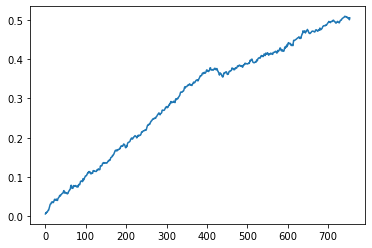

In [40]:
pnl_old = test(new_frames,covariance,y_frames,coef_mean3,1000)
print('The total cumulative return of this strategy is '+str(pnl_old[-1]*100)+' %')

In [82]:
print('The total cumulative return of this strategy is '+str(pnl_old[-1]*100)+' %')

The total cumulative return of this strategy is 50.431685332121546 %


## Test in the future (2007 )

100 days finish!
200 days finish!
The total cumulative return of this strategy is 14.532174092807695 %


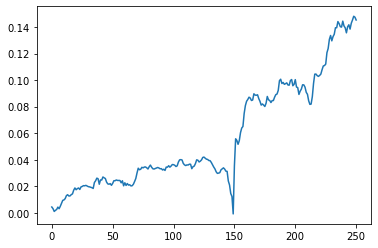

In [80]:
pnl_2007 = test(new_frames2,covariance_test,y_frames2, coef_mean3, 300)
print('The total cumulative return of this strategy is '+str(pnl_2007[-1]*100)+' %')

In [85]:
print('The total cumulative return of this strategy is '+str(pnl_2007[-1]*100)+' %')

The total cumulative return of this strategy is 14.532174092807695 %


## Comparison Conclusion

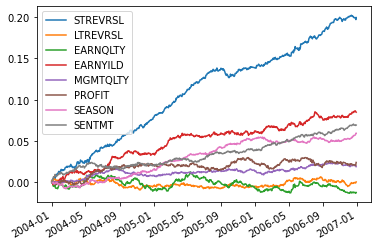

In [83]:
# all eight alpha performance based on ols from 2004 to 2007
facret = {}

for date in frames:
    facret[date] = estimate_factor_returns(frames[date], list(alpha_factors)).params

    
facret_df = pd.DataFrame(index = my_dates)
for dt in my_dates: 
    for alp in alpha_factors: 
        facret_df.at[dt, alp] = facret[dt.strftime('%Y%m%d')][alp]

facret_df.cumsum().plot()

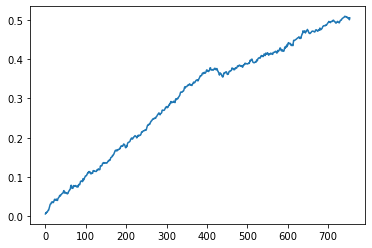

In [96]:
plt.plot(pnl_old)

In [88]:
print('The total residual return is ' + str(sum(y_data['Ret'])))
print('The cumulative return of simply combining all alpha factors is' + str(np.sum(np.sum(facret_df))))
print('The total cumulative return of out strategy is '+str(pnl_old[-1]))

The total residual return is 1.0445998411987356
The cumulative return of simply combining all alpha factors is0.4450033863261572
The total cumulative return of out strategy is 0.5043168533212155


We can clearly see that our strategy based on ElasticNet perfoms higher cumulative return than simply combining all alpha factors. Thus I think we found a better alpha factor strategy. 

Also, we can see that there is a large difference between actual residual return and cumulative return of strategy. Maybe there exists some alpha factors of other information which we didn't consider into the strategy. Thus I think a future improvement direction is to consider more reasonable alpha factors into the strategy and explore some new alpha factors to help us get a higher excess return than other investors in the market. 



In [86]:
# The coefficients of all eight alpha factors is 
# coef_mean3